# RAG
In this section we will start to see the glimpses of RAG. We start by figuring out how to handle external documents. We have already been exposed to building a database in the previous section, and we will use this knowledge to build a database over an example document.

As with data storage, we have many, _**many**_ options for processing external documents. In this section we will make use of LlamaIndex. The approach will likely vary depending on the nature of your documents - html, pdf, word, folders, etc.

Here, we focus on parsing a single PDF using `llama_index` and `PyMuPDFReader`.

In [58]:
from llama_index.readers.file import PyMuPDFReader
from llama_index.core.node_parser import SentenceSplitter

from pydantic import BaseModel, Field

import fitz

from PIL import Image
import matplotlib.pyplot as plt

import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

import dotenv
import os

from openai import OpenAI

from jinja2 import Environment, FileSystemLoader, select_autoescape
from typing import Any

dotenv.load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [2]:
loader = PyMuPDFReader()
documents = loader.load(file_path="data/paper.pdf")

In [3]:
len(documents)

30

This list contains 1 item for each page.

In [4]:
print(documents[0].text[:1000] + "...")

A Philosophical Introduction to Language Models
Part I: Continuity With Classic Debates
Raphaël Millière
Department of Philosophy
Macquarie University
raphael.milliere@mq.edu.eu
Cameron Buckner
Department of Philosophy
University of Houston
cjbuckner@uh.edu
Abstract
Large language models like GPT-4 have achieved remarkable proficiency in a broad spec-
trum of language-based tasks, some of which are traditionally associated with hallmarks of
human intelligence. This has prompted ongoing disagreements about the extent to which
we can meaningfully ascribe any kind of linguistic or cognitive competence to language
models. Such questions have deep philosophical roots, echoing longstanding debates
about the status of artificial neural networks as cognitive models. This article–the first part
of two companion papers–serves both as a primer on language models for philosophers,
and as an opinionated survey of their significance in relation to classic debates in the
philosophy cognitive science,

## Extracting images
It is probably handy to have the images extracted from the pdf. This is not always easy to do, but for this paper, we can use PyMuPDF to extract the images. Objects in a pdf are identified by a `xref` (cross reference) number.

If you know this number, you can extract the image. But how do you find the `xref` number? One method is use PyMuPDF's image extraction functions. We can just loop through all `xref`s and try and extract the image. If it doesn't work, then it's not an image! PyMuPDF will do most of this for us.

In [5]:
def get_images(path: str):
    doc = fitz.open(path)
    for p, page in enumerate(doc):
        images = page.get_images()
        if len(images) > 0:
            print(f"Page {p} has {len(images)} images")
            for i, img in enumerate(images):
                xref = img[0]
                mref = img[1]
                basepix = fitz.Pixmap(doc,xref)
                maskpix = fitz.Pixmap(doc,mref)
                pix = fitz.Pixmap(basepix, maskpix)
                pix.save(f"./data/page_{p}_image_{i}.png")
    print("Done")


In [6]:
get_images("data/paper.pdf")

Page 4 has 1 images
Page 6 has 1 images
Page 10 has 1 images
Done


If we inspect one of these images, we can see that sure enough, it is a correct image.

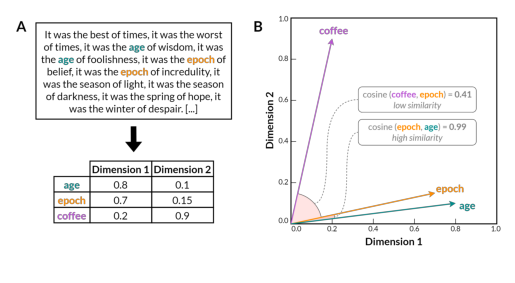

In [7]:
img = Image.open("data/page_4_image_0.png")
plt.imshow(img)
plt.axis("off")
plt.show()

In some cases, this might not be possible. Another method is to convert the pdf pages to images. We can then pass the images to a vision LLM and ask it to extract the images. 

## Creating a vector database

Now we have our documents, we can create a vector database. We will use Chroma as before.

First, we use the `text_parser` we created before to split the documents into chunks, and create indices. Essentially, the process is:

- Split the document into chunks;
- Add the chunks to a list;
- Add the chunks to a database, assigning a unique index, and any metadata to the chunks.

The splitting can occur in a few different ways: at `.`, page-breaks, paragraphs, sentences. You can also choose different chunk sizes and overlap sizes.

We use the `SentenceSplitter` from LlamaIndex, and just pick some generic parameters.

In [15]:
def chunker(chunk_size: int, overlap: int, documents: Any) -> tuple[list[str], list[int]]:
    text_parser = SentenceSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
    )

    text_chunks = []
    doc_idxs = []
    for doc_idx, doc in enumerate(documents):
        cur_text_chunks = text_parser.split_text(doc.text)
        text_chunks.extend(cur_text_chunks)
        doc_idxs.extend([doc_idx] * len(cur_text_chunks))

    return text_chunks, doc_idxs

text_chunks, doc_idxs = chunker(chunk_size=1024, overlap=128, documents=documents)

len(text_chunks)

34

Reusing roughly the same database structure as before:

In [16]:
class DocumentDB:
    def __init__(self, name: str, model_name: str = "text-embedding-3-small"):
        self.model_name = model_name
        self.client = chromadb.PersistentClient(path="./")
        self.embedding_function = OpenAIEmbeddingFunction(api_key=OPENAI_API_KEY, model_name=model_name)
        self.chat_db = self.client.create_collection(name=name, embedding_function=self.embedding_function, metadata={"hnsw:space": "cosine"})
        self.id_counter = 0


    def add_chunks_to_db(self, chunks: list[str], doc_idxs: list[int], metadata: dict = {}):
        """Add text chunks to the database.

        Args:
            chunks (list[str]): List of text chunks.
            doc_idxs (list[int]): List of corresponding document indices.
        """
        self.chat_db.add(
            documents=chunks,
            metadatas=[{"doc_idx": idx} for idx in doc_idxs],
            ids=[f"chunk_{self.id_counter + i}" for i in range(len(chunks))]
        )
        self.id_counter += len(chunks)


    def get_all_entries(self) -> dict:
        """Grab all of the entries in the database.

        Returns:
            dict: All entries in the database.
        """
        return self.chat_db.get()
    

    def clear_db(self, reinitialize: bool = True):
        """Clear the database of all entries, and reinitialize it.

        Args:
            reinitialize (bool, optional): _description_. Defaults to True.
        """
        self.client.delete_collection(self.chat_db.name)
        # re-initialize the database
        if reinitialize:
            self.__init__(self.chat_db.name, self.model_name)


    def query_db(self, query_text: str, n_results: int = 2) -> dict:
        """Given some query text, return the n_results most similar entries in the database.

        Args:
            query_text (str): The text to query the database with.
            n_results (int): The number of results to return.

        Returns:
            dict: The most similar entries in the database.
        """
        return self.chat_db.query(query_texts=[query_text], n_results=n_results)

Now we add our chunks to the database:

In [17]:
doc_db = DocumentDB("paper_db")
doc_db.add_chunks_to_db(chunks=text_chunks, doc_idxs=doc_idxs)

If you have already created the database then you will get an error if you try to run this again. You'll need to delete the `chroma.sqlite3` file and the folder with a name consisting of a long string of numbers and letters.

We now try a query and see what results we get back:

In [15]:
sample_query = "Abstract"
results = doc_db.query_db(sample_query, n_results=3)
print(f"Sample query results for '{sample_query}':")
results

Sample query results for 'Abstract':


{'ids': [['chunk_30', 'chunk_12', 'chunk_11']],
 'distances': [[0.7026290379547134, 0.7119312067010161, 0.7212011058066763]],
 'metadatas': [[{'doc_idx': 27}, {'doc_idx': 11}, {'doc_idx': 10}]],
 'embeddings': None,
 'documents': [['A Philosophical Introduction to Language Models\nPart I\nQiu, L., Shaw, P., Pasupat, P., Nowak, P., Linzen, T., Sha, F. & Toutanova, K. (2022), Improving\nCompositional Generalization with Latent Structure and Data Augmentation, in ‘Proceedings of the\n2022 Conference of the North American Chapter of the Association for Computational Linguistics:\nHuman Language Technologies’, Association for Computational Linguistics, Seattle, United States,\npp. 4341–4362.\nQuilty-Dunn, J., Porot, N. & Mandelbaum, E. (2022), ‘The Best Game in Town: The Re-Emergence of\nthe Language of Thought Hypothesis Across the Cognitive Sciences’, Behavioral and Brain Sciences\npp. 1–55.\nRaffel, C., Shazeer, N., Roberts, A., Lee, K., Narang, S., Matena, M., Zhou, Y., Li, W. & Liu, P.

This is all pretty messy, but we can see that we have

`'documents'` The documents returned by the database query

`'metadatas'` Any metadata we wanted to include, in this case only the index. But we could easily include the author and title of the paper...

`'distances'` The similarity measure between the query and the returned context.

The next step is to put these contexts, along with the query, into an LLM.

In [18]:
client = OpenAI()

Our prompt will be simple for now. We use the standard way to load Jinja templates.

In [27]:
def load_template(template_filepath: str, arguments: dict[str, Any]) -> str:
    env = Environment(
        loader=FileSystemLoader(searchpath='./'),
        autoescape=select_autoescape()
    )
    template = env.get_template(template_filepath)
    return template.render(**arguments)

system_prompt = load_template(
    template_filepath="prompts/rag_system_prompt.jinja",
    arguments={}
)

---
```
You are a helpful academic assistant that is an expert at extracting information from academic papers. You will be given a query, and some chunks of text that corresponds to a document. You will also be given the cosine similarity of the query with the text chunks.
You must answer the query using the information in the text.
Your answer must be concise and to the point.
If you are unsure of something, you should say that you are unsure.

### Input Format ###

Query: <query>
Context: <text chunk>\n\n"
Cosine Similarity: <similarity>
----------
```
---

We now need to combine the call to the retriever, along with combining the context into a function.

In [28]:
def combine_context(documents: list[str], scores: list[float]) -> str:
    string = ""
    for document, score in zip(documents, scores):
        string += f"{document}\nCosine distance: {score:.2f}\n{'-'*10}\n"
    return string

def get_context(user_input: str, n_results: int = 2, doc_db: DocumentDB = doc_db) -> str:
    results = doc_db.query_db(user_input, n_results=n_results)
    context_list = results["documents"][0]
    combined_context = combine_context(context_list, results["distances"][0])
    if not combined_context:
        combined_context = "No relevant chat history found."
    return combined_context

query = "What are the main findings of this paper?"
context = get_context(query, n_results=3)

In [29]:
user_prompt = (
    f"Query: {query}\n\n"
    f"Context: {context}"
)

print(user_prompt)

Query: What are the main findings of this paper?

Context: A Philosophical Introduction to Language Models
Part I
were all they could do, LLMs like GPT-4 would simply be Blockheads come to life. Compare this
to a human student who had found a test’s answer key on the Internet and reproduced its answers
without any deeper understanding; such regurgitation would not be good evidence that the student
was intelligent. For these reasons, “data contamination”–when the training set contains the very
question on which the LLM’s abilities are assessed–is considered a serious concern in any report of an
LLM’s performance, and many think it must be ruled out by default when comparing human and
LLM performance (Aiyappa et al. 2023). Moreover, GPT-4’s pre-training and fine-tuning requires
an investment in computation on a scale available only to well-funded corporations and national
governments–a process which begins to look quite inefficient when compared to the data and energy
consumed by the squ

In [30]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ],
    stream=True,
    temperature=0.0
)

for chunk in response:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="")

The main findings of the paper highlight that large language models (LLMs) like GPT-4 demonstrate remarkable proficiency in various language-based tasks, prompting debates about their cognitive and linguistic competence. The authors argue that while LLMs can regurgitate information, they also exhibit the ability to blend patterns from their training data to produce novel outputs, suggesting a form of creativity and rational decision-making. The paper emphasizes the importance of empirical evidence in understanding the internal mechanisms of LLMs and challenges traditional assumptions about artificial neural networks. It serves as both a primer for philosophers and an opinionated survey of the philosophical implications of LLMs in relation to cognitive science and artificial intelligence.

Meh.

This is OK, but not all of these chunks are massively useful. This highlights one of the most important parts of building RAG pipelines: RAG systems live and die on the quality of the retrieval process. And the retrieval process depends strongly on the quality of the embeddings created from the documents.

But also, consider what question we are actually asking? 

```python
"What are the main findings of this paper?"
```

The only way we are going to get meaningful chunks returned, ready to be ingested by the LLM, is if there are similar chunks within the body of text. In other words, a phrase similar to "main finding of this paper" would have to appear in one of the chunks! So we have two main issues:

1. The quality of the chunks are not very good due to the parsing process;
2. We have to know what kinds of questions to ask of our models.

In this case, it would have probably been better to just stuff the entire document into the model context window (this technique is literally called stuffing).

Let's ask another question to demonstrate this:

In [33]:
def combine_context(documents: list[str], scores: list[float]) -> str:
    string = ""
    for document, score in zip(documents, scores):
        string += f"{document}\nCosine distance: {score:.2f}\n{'-'*10}\n"
    return string


def rag_query(query: str, n_context, return_context=False):
    query_results = doc_db.query_db(query, n_results=n_context)
    context_list = query_results["documents"][0]
    combined_context = combine_context(context_list, query_results["distances"][0])
    if not combined_context:
        combined_context = "No relevant chat history found."


    system_prompt = load_template(
        template_filepath="prompts/rag_system_prompt.jinja",
        arguments={}
    )

    user_prompt = (
        f"Query: {query}\n\n"
        f"Context: {combined_context}"
    )

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        stream=False,
        temperature=0.0
    )
    
    if return_context:
        return response.choices[0].message.content, context_list
    else:
        return response.choices[0].message.content


response = rag_query(
    query="Who wrote this paper?",
    n_context=2
)

print(response)    

The authors of the paper "A Philosophical Introduction to Language Models" are not explicitly mentioned in the provided text chunks. Therefore, I am unsure who wrote this paper.


Of course, this is ridiculous. We know that this paper was written by Raphaël Millière and Cameron Buckner. But how would the retriever know how to receive the correct information? Where in the text would there be anything similar to, "Who wrote this paper?". You might get lucky if you include the word "authors", but try that for this paper, and you'll get the same result.

In [40]:
response = rag_query(
    query="Who wrote this paper? If there is no explicitely stated author, then make a best guess.",
    n_context=5
)
print(response)   

The paper does not explicitly state an author. However, based on the context provided, a best guess for the author could be "Buckner, C. J." as they are mentioned multiple times in the text and seem to be discussing relevant topics related to language models and philosophy.


Give the model a little more freedom, and it can sometimes infer one of the authors. Note that we can actually extract the authors in a couple of ways - sometimes they are included in the metadata of the pdf, but their names will usually be in the first document chunk!

You could use this information and either add it as metadata to the entire collection or to individual chunks.

## Further work

This example is a very naive form of RAG. Additional techniques might include hybrid search or contextual retrieval.